# Image classification system for backside wafer defects

In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from concurrent.futures import ThreadPoolExecutor


# Histogram for each category - normalized sum

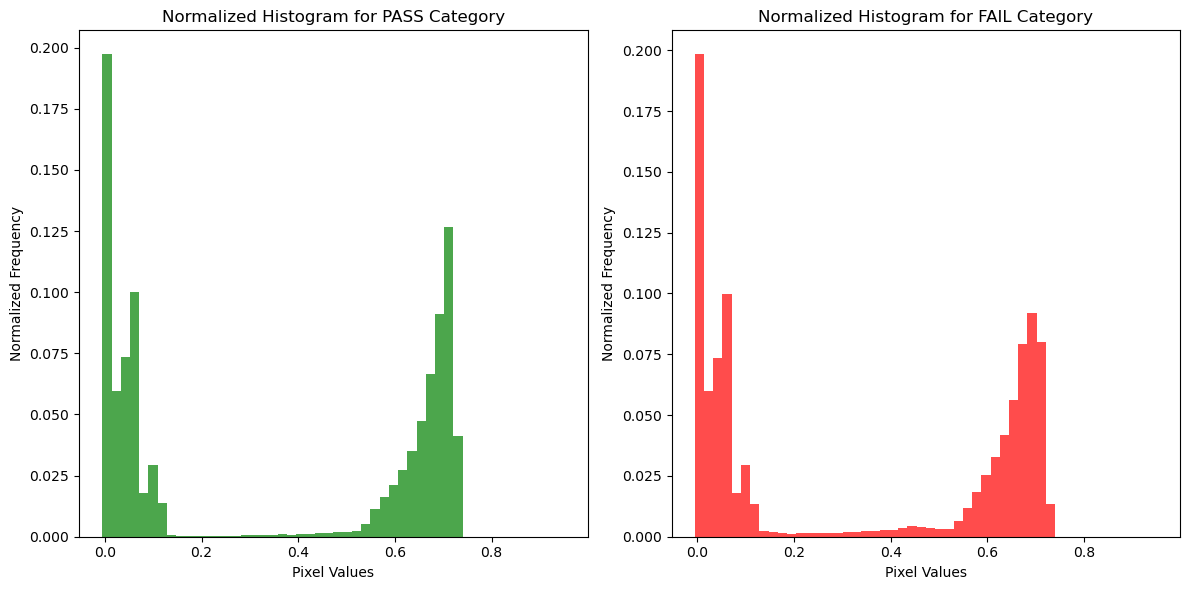

Differences between PASS and FAIL histograms (normalized frequencies):
[-1.05654028e-03 -3.70404167e-04 -3.05583333e-05  1.60447222e-04
 -2.08684722e-04 -1.60050000e-04  3.50840278e-04 -1.34607778e-03
 -1.48692917e-03 -1.06612083e-03 -9.30427778e-04 -9.73559722e-04
 -1.06442083e-03 -1.07173056e-03 -1.16552639e-03 -1.13510278e-03
 -1.16710833e-03 -1.19675556e-03 -1.43923750e-03 -1.56165694e-03
 -1.74961250e-03 -1.87351667e-03 -2.39201250e-03 -2.75124444e-03
 -2.56430556e-03 -1.75164861e-03 -9.61518056e-04 -7.95137500e-04
 -1.44782083e-03 -5.97850000e-04 -2.01168472e-03 -4.10471528e-03
 -5.57458056e-03 -6.86670417e-03 -8.75198611e-03 -1.24715000e-02
 -7.92237500e-04  4.64435861e-02  2.79311361e-02 -1.42777778e-06
 -1.34305556e-06  8.23611111e-07 -2.39861111e-06  3.61666667e-06
  2.56944444e-07  6.47222222e-07  1.57916667e-06 -2.40277778e-07
  8.11111111e-07  6.31944444e-07]


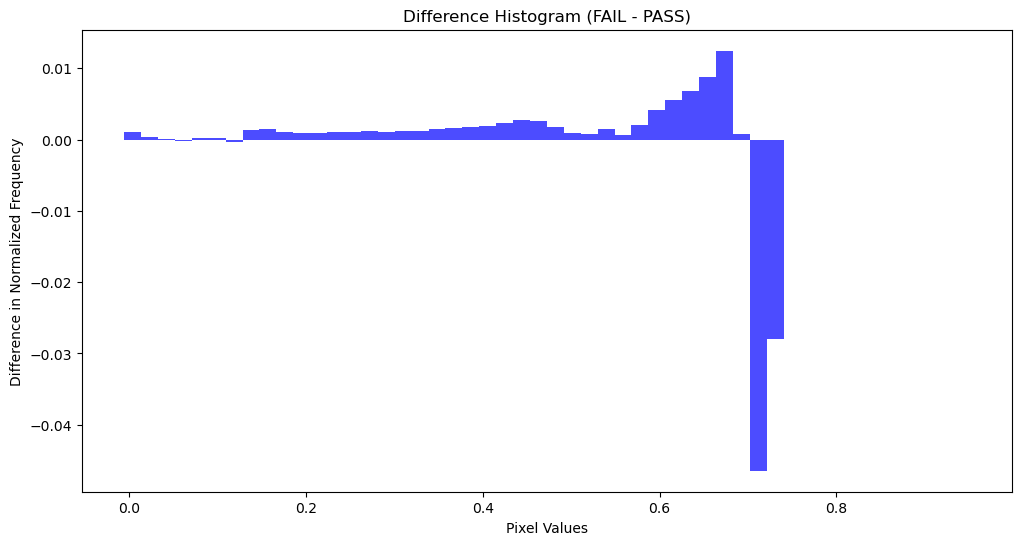

Differences between FAIL and PASS histograms (normalized frequencies):
[ 1.05654028e-03  3.70404167e-04  3.05583333e-05 -1.60447222e-04
  2.08684722e-04  1.60050000e-04 -3.50840278e-04  1.34607778e-03
  1.48692917e-03  1.06612083e-03  9.30427778e-04  9.73559722e-04
  1.06442083e-03  1.07173056e-03  1.16552639e-03  1.13510278e-03
  1.16710833e-03  1.19675556e-03  1.43923750e-03  1.56165694e-03
  1.74961250e-03  1.87351667e-03  2.39201250e-03  2.75124444e-03
  2.56430556e-03  1.75164861e-03  9.61518056e-04  7.95137500e-04
  1.44782083e-03  5.97850000e-04  2.01168472e-03  4.10471528e-03
  5.57458056e-03  6.86670417e-03  8.75198611e-03  1.24715000e-02
  7.92237500e-04 -4.64435861e-02 -2.79311361e-02  1.42777778e-06
  1.34305556e-06 -8.23611111e-07  2.39861111e-06 -3.61666667e-06
 -2.56944444e-07 -6.47222222e-07 -1.57916667e-06  2.40277778e-07
 -8.11111111e-07 -6.31944444e-07]


In [60]:
categories = ['PASS', 'FAIL']
flat_data_arr = []  # input array
target_arr = []  # output array
datadir = "C:\\Users\\scallred\\ImageClassifierCapstone\\"

def process_image(category, img):
    img_array = imread(os.path.join(datadir, category, img))
    img_resized = resize(img_array, (1000, 1000, 3))  # resize image
    return img_resized.flatten(), categories.index(category)

with ThreadPoolExecutor() as executor:
    futures = []
    for category in categories:
        path = os.path.join(datadir, category)
        for img in os.listdir(path):
            futures.append(executor.submit(process_image, category, img))
    
    for future in futures:
        flat_data, target = future.result()
        flat_data_arr.append(flat_data)
        target_arr.append(target)

flat_data = np.array(flat_data_arr)
targets = np.array(target_arr)

# Create histograms for 'PASS' and 'FAIL' categories
pass_indices = np.where(targets == categories.index('PASS'))[0]
fail_indices = np.where(targets == categories.index('FAIL'))[0]

plt.figure(figsize=(12, 6))

# Determine the common range for x-axis (pixel values)
all_pixel_values = flat_data.flatten()
min_pixel_value = np.min(all_pixel_values)
max_pixel_value = np.max(all_pixel_values)

# Calculate the normalized sum for each category
pass_hist, pass_bins = np.histogram(flat_data[pass_indices].flatten(), bins=50, range=(min_pixel_value, max_pixel_value))
fail_hist, fail_bins = np.histogram(flat_data[fail_indices].flatten(), bins=50, range=(min_pixel_value, max_pixel_value))

pass_hist_normalized = pass_hist / np.sum(pass_hist)
fail_hist_normalized = fail_hist / np.sum(fail_hist)

plt.subplot(1, 2, 1)
plt.bar(pass_bins[:-1], pass_hist_normalized, width=np.diff(pass_bins), color='g', alpha=0.7)
plt.title('Normalized Histogram for PASS Category')
plt.xlabel('Pixel Values')
plt.ylabel('Normalized Frequency')

plt.subplot(1, 2, 2)
plt.bar(fail_bins[:-1], fail_hist_normalized, width=np.diff(fail_bins), color='r', alpha=0.7)
plt.title('Normalized Histogram for FAIL Category')
plt.xlabel('Pixel Values')
plt.ylabel('Normalized Frequency')

plt.tight_layout()
plt.show()

# Compare the two histograms to determine the differences
difference = pass_hist_normalized - fail_hist_normalized

print("Differences between PASS and FAIL histograms (normalized frequencies):")
print(difference)

# Subtract the PASS histogram from the FAIL histogram
difference_histogram = fail_hist_normalized - pass_hist_normalized

# Plot the difference histogram
plt.figure(figsize=(12, 6))
plt.bar(pass_bins[:-1], difference_histogram, width=np.diff(pass_bins), color='b', alpha=0.7)
plt.title('Difference Histogram (FAIL - PASS)')
plt.xlabel('Pixel Values')
plt.ylabel('Difference in Normalized Frequency')
plt.show()

print("Differences between FAIL and PASS histograms (normalized frequencies):")
print(difference_histogram)


# View the images (downsampled)

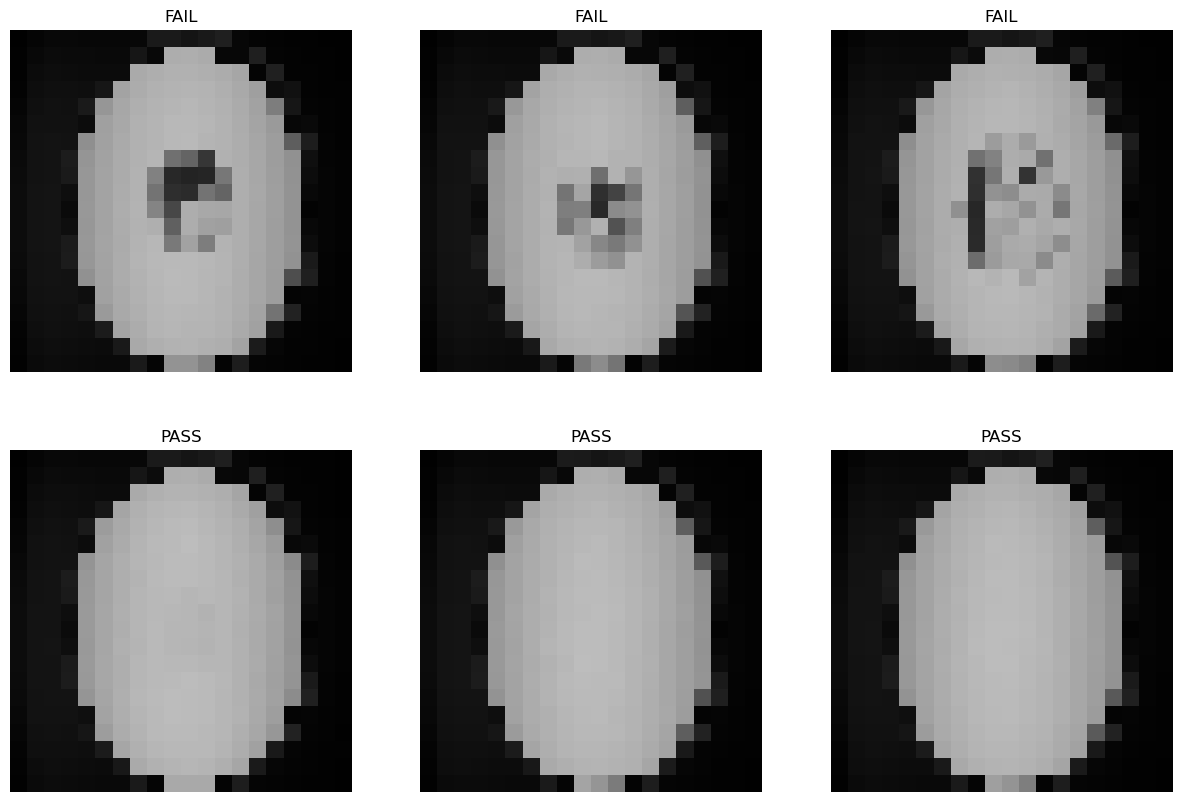

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Filter the indices of images that belong to the 'FAIL' and 'PASS' categories
fail_indices = [i for i, target in enumerate(targets) if categories[target] == 'FAIL']
pass_indices = [i for i, target in enumerate(targets) if categories[target] == 'PASS']

# Select 3 images from each category
selected_fail_indices = fail_indices[:3]
selected_pass_indices = pass_indices[:3]

# Function to downsample and convert image data to float values
def process_image_data(indices):
    processed_images = []
    for idx in indices:
        image_data = flat_data[idx].reshape(1000, 1000, 3)
        resized_image_data = image_data[::50, ::50]  # Downsample to 20x20
        processed_images.append(resized_image_data.astype(float))
    return processed_images

# Process images
fail_images = process_image_data(selected_fail_indices)
pass_images = process_image_data(selected_pass_indices)

# Plot the images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (fail_img, pass_img) in enumerate(zip(fail_images, pass_images)):
    axes[0, i].imshow(fail_img)
    axes[0, i].set_title("FAIL")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(pass_img)
    axes[1, i].set_title("PASS")
    axes[1, i].axis('off')

plt.show()


In [18]:
x_train, x_test, y_train, y_test = train_test_split(flat_data, targets, test_size=0.3)


In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68, 3000000), (68,), (30, 3000000), (30,))

# Grid search SVC - kernel of SVC

In [22]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

# Create a SVC classifier
svc = SVC()

# Define the grid of hyperparameters 'params'
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Perform grid search
grid_search = GridSearchCV(estimator=svc, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

# Get the optimal hyperparameters from the grid search
best_params = grid_search.best_params_

# Train the classifier with the optimal hyperparameters
svc = SVC(kernel=best_params['kernel'])
svc.fit(X_train, y_train)

#average fit time
cv_results = cross_validate(svc, X_train, y_train, cv=5, return_train_score=False)
avg_fit_time = np.mean(cv_results['fit_time'])
print(f'Average fit time for SVC: {avg_fit_time} seconds')

# Make predictions on the train and test sets
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

# Calculate the train and test scores
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

# Print the train score, test score, and optimal hyperparameters
print(f"Train score: {train_score}")
print(f"Test score: {test_score}")
print(f"Optimal hyperparameters: {best_params}")

Average fit time for SVC: 2.557646369934082 seconds
Train score: 1.0
Test score: 1.0
Optimal hyperparameters: {'kernel': 'linear'}


In [ ]:
# Grid Search Results

# Average fit time for SVC: 2.2186885356903074 seconds
# Train score: 1.0
# Test score: 1.0
# Optimal hyperparameters: {'kernel': 'linear'}

# Grid search SVC - C value

In [23]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

# Create a SVC classifier
svc = SVC(kernel='linear')

# Define the grid of hyperparameters 'params'
params = {
    'C': [0.1, 1, 10, 100, 1000]
}

# Perform grid search
grid_search = GridSearchCV(estimator=svc, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

# Get the optimal hyperparameters from the grid search
best_params = grid_search.best_params_

# Train the classifier with the optimal hyperparameters
svc = SVC(kernel='linear', C=best_params['C'])
svc.fit(X_train, y_train)

# Average fit time
cv_results = cross_validate(svc, X_train, y_train, cv=5, return_train_score=False)
avg_fit_time = np.mean(cv_results['fit_time'])
print(f'Average fit time for SVC: {avg_fit_time} seconds')

# Make predictions on the train and test sets
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

# Calculate the train and test scores
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

# Print the train score, test score, and optimal hyperparameters
print(f"Train score: {train_score}")
print(f"Test score: {test_score}")
print(f"Optimal hyperparameters: {best_params}")


Average fit time for SVC: 2.2567373275756837 seconds
Train score: 1.0
Test score: 1.0
Optimal hyperparameters: {'C': 0.1}


In [ ]:
# Average fit time for SVC: 2.341265058517456 seconds
# Train score: 1.0
# Test score: 1.0
# Optimal hyperparameters: {'C': 0.1}

# Grid search Logistic Regression

In [ ]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(flat_data, targets, test_size=0.3, random_state=42)

# Defining the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

# Initializing the logistic regression model
log_reg = LogisticRegression(max_iter=10000)

# Setting up the grid search
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy')

# Fitting the grid search
grid_search.fit(x_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


In [ ]:
# Best Parameters: {'C': 1, 'solver': 'lbfgs'}
# Best Score: 0.96

# Train logistic regression model

In [45]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(flat_data, targets, test_size=0.3, random_state=42)

# Initializing and training the logistic regression model
log_reg = LogisticRegression(max_iter=10000, C=1,solver='lbfgs')
log_reg.fit(x_train, y_train)


LogisticRegression(C=1, max_iter=10000)

### Confusion matrix

In [47]:
y_pred = log_reg.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         5

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:
[[25  0]
 [ 0  5]]


# Train SVC model

In [88]:
x_train, x_test, y_train, y_test = train_test_split(flat_data, targets, test_size=0.5)

svc = svm.SVC(kernel='linear', C=0.1)
svc.fit(x_train, y_train)


SVC(C=0.1, kernel='linear')

In [90]:
y_pred = svc.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.9591836734693877
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        41
           1       1.00      0.75      0.86         8

    accuracy                           0.96        49
   macro avg       0.98      0.88      0.92        49
weighted avg       0.96      0.96      0.96        49

Confusion Matrix:
[[41  0]
 [ 2  6]]


# Histogram of all images processed

In [ ]:
categories = ['PASS', 'FAIL']
datadir = "C:\\Users\\scallred\\ImageClassifierCapstone\\"

def process_image(category, img):
    img_array = imread(os.path.join(datadir, category, img))
    img_resized = resize(img_array, (1000, 1000, 3))  # resize image
    return img_resized.flatten(), categories.index(category)

with ThreadPoolExecutor() as executor:
    futures = []
    for category in categories:
        path = os.path.join(datadir, category)
        for img in os.listdir(path):
            futures.append(executor.submit(process_image, category, img))
    
    for future in futures:
        flat_data, target = future.result()
        
        # Plot histogram for each image
        plt.figure()
        plt.hist(flat_data, bins=50, color='b', alpha=0.7)
        plt.title(f'Histogram for {categories[target]} Category - Image')
        plt.xlabel('Pixel Values')
        plt.ylabel('Frequency')
        plt.show()
